# Intro to keras as part of Tensorflow
    - Load MNIST dataset
    - Linear model
    - Neural model
    - Convolutional model

In [1]:
from __future__ import print_function

#Basic libraries
import numpy as np
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)
import time

#Show images
import matplotlib.pyplot as plt
%matplotlib inline
# plt configuration
plt.rcParams['figure.figsize'] = (10, 10)        # size of images
plt.rcParams['image.interpolation'] = 'nearest'  # show exact image
plt.rcParams['image.cmap'] = 'gray'  # use grayscale 


Tensorflow version:  1.4.0


In [2]:
# Select GPU
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16199429511882733634
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11990125773
locality {
  bus_id: 1
}
incarnation: 13662178690377871925
physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:06:00.0, compute capability: 6.1"
]


## Get some data

In [3]:
# Import mnist dataset and rescale between [0,1]
from tensorflow.contrib.keras import datasets

(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data(path='mnist.npz')
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.

print('X train shape: ',X_train.shape)
print('y train shape: ',y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (60000, 28, 28)
y train shape:  (60000,)
X test shape:  (10000, 28, 28)
y test shape:  (10000,)


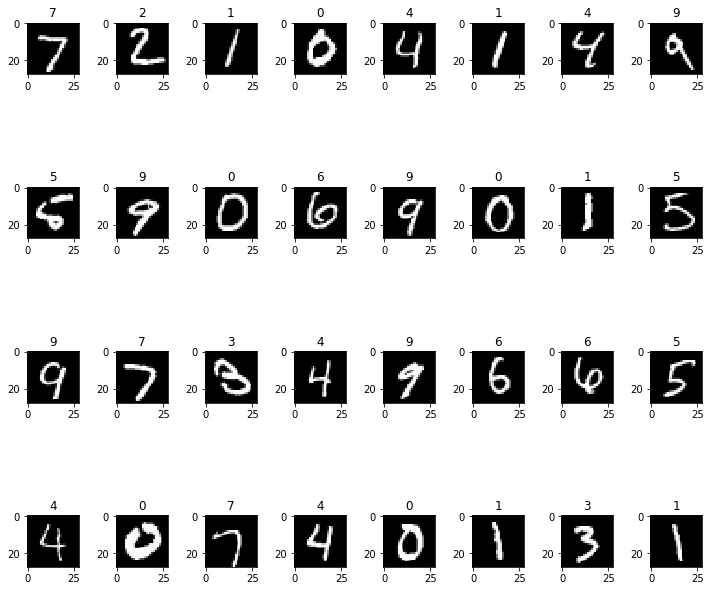

In [4]:
#Examine the data
fig = plt.figure()
for n, i in enumerate(range(32)): 
    a = fig.add_subplot(4,8,n+1)
    a.set_title(str(y_test[i]))
    fig.tight_layout()
    plt.imshow(X_test[i])
    

## Linear model

In [5]:
from tensorflow.contrib.keras import models, layers, optimizers, callbacks

print('Linear model...')
images = layers.Input(batch_shape=(None, 28, 28), dtype='float32', name='Images') 
flat = layers.Flatten(name='Flat_image')(images)
output = layers.Dense(10, activation='softmax', name='Dense_output')(flat)

# Model Architecture defined
model_linear = models.Model(inputs=images, outputs=output)
model_linear.summary()


Linear model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Images (InputLayer)          (None, 28, 28)            0         
_________________________________________________________________
Flat_image (Flatten)         (None, 784)               0         
_________________________________________________________________
Dense_output (Dense)         (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Select optimizer and compile model
sgd_optimizer = optimizers.SGD(lr=0.01)
model_linear.compile(loss='sparse_categorical_crossentropy', 
                     optimizer=sgd_optimizer, metrics=['accuracy'])

In [8]:
# Train the model
start = time.time()

tb_callback_ln = callbacks.TensorBoard(log_dir='/tmp/tensorboard/keras/linear/')

history_linear = model_linear.fit(X_train, y_train, batch_size=128, epochs=50,
                                  verbose=1, validation_data=(X_test, y_test), callbacks=[tb_callback_ln])

print('Seconds to train: ', time.time() - start)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s - loss: 1.2829 - acc: 0.6961 - val_loss: 0.8077 - val_acc: 0.8352
Epoch 2/50
60000/60000 [==============================] - 1s - loss: 0.7136 - acc: 0.8409 - val_loss: 0.6061 - val_acc: 0.8625
Epoch 3/50
60000/60000 [==============================] - 1s - loss: 0.5860 - acc: 0.8593 - val_loss: 0.5252 - val_acc: 0.8733
Epoch 4/50
60000/60000 [==============================] - 1s - loss: 0.5249 - acc: 0.8682 - val_loss: 0.4798 - val_acc: 0.8805
Epoch 5/50
60000/60000 [==============================] - 1s - loss: 0.4876 - acc: 0.8746 - val_loss: 0.4498 - val_acc: 0.8853
Epoch 6/50
60000/60000 [==============================] - 1s - loss: 0.4619 - acc: 0.8796 - val_loss: 0.4284 - val_acc: 0.8890
Epoch 7/50
60000/60000 [==============================] - 1s - loss: 0.4429 - acc: 0.8831 - val_loss: 0.4125 - val_acc: 0.8920
Epoch 8/50
60000/60000 [==============================] - 1s 

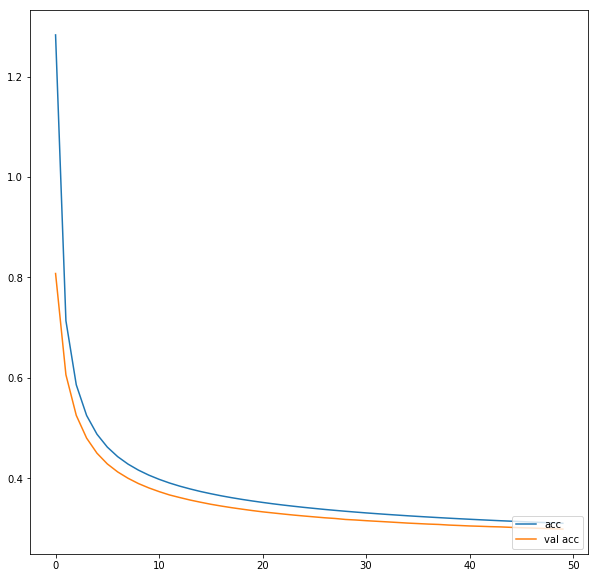

In [10]:
plt.plot(history_linear.history['loss'], label='acc')
plt.plot(history_linear.history['val_loss'], label='val acc')
plt.legend(loc='lower right')
plt.show()

In [19]:
# Score and select prediction with max prob
import numpy as np
p_test = model_linear.predict(X_test)
pred_test = np.argmax(p_test, axis=1)

#Evaluate the confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,pred_test))

[[ 959    0    2    2    0    4   10    1    2    0]
 [   0 1104    2    2    1    3    4    1   18    0]
 [   8   10  908   15   14    2   14   14   40    7]
 [   3    1   21  917    0   25    3   13   18    9]
 [   1    1    5    1  914    0   12    2    8   38]
 [  10    4    6   38   11  766   14    6   29    8]
 [  11    3    4    2   11   14  911    1    1    0]
 [   2   13   23    6    8    0    0  939    3   34]
 [   8   10    5   24    9   25   11   14  859    9]
 [  11    7    3   12   39    8    0   21    6  902]]


## Neural network model 

In [11]:
print('NN model...')

images = layers.Input(batch_shape=(None, 28, 28), dtype='float32', name='Images') 
flat   = layers.Flatten(name='Flat_image')(images)
dense  = layers.Dense(500, activation='relu', name='Dense_layer')(flat)
output = layers.Dense(10, activation='softmax', name='Dense_output')(dense)

# Model Architecture defined
model_nn = models.Model(inputs=images, outputs=output)
model_nn.summary()


NN model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Images (InputLayer)          (None, 28, 28)            0         
_________________________________________________________________
Flat_image (Flatten)         (None, 784)               0         
_________________________________________________________________
Dense_layer (Dense)          (None, 500)               392500    
_________________________________________________________________
Dense_output (Dense)         (None, 10)                5010      
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
_________________________________________________________________


In [12]:
sgd_optimizer = optimizers.SGD(lr=0.01)
model_nn.compile(loss='sparse_categorical_crossentropy', 
                 optimizer=sgd_optimizer, metrics=['accuracy'])


In [13]:
# Train the model
start = time.time()

tb_callback_nn = callbacks.TensorBoard(log_dir='/tmp/tensorboard/keras/neural/')

history_nn = model_nn.fit(X_train, y_train, batch_size=128, epochs=50,
                    verbose=1, validation_data=(X_test, y_test), callbacks=[tb_callback_nn])

print('Seconds to train: ', time.time() - start)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s - loss: 1.0764 - acc: 0.7583 - val_loss: 0.5894 - val_acc: 0.8666
Epoch 2/50
60000/60000 [==============================] - 1s - loss: 0.5166 - acc: 0.8729 - val_loss: 0.4320 - val_acc: 0.8889
Epoch 3/50
60000/60000 [==============================] - 1s - loss: 0.4191 - acc: 0.8893 - val_loss: 0.3729 - val_acc: 0.9009
Epoch 4/50
60000/60000 [==============================] - 1s - loss: 0.3742 - acc: 0.8983 - val_loss: 0.3424 - val_acc: 0.9069
Epoch 5/50
60000/60000 [==============================] - 1s - loss: 0.3468 - acc: 0.9047 - val_loss: 0.3211 - val_acc: 0.9130
Epoch 6/50
60000/60000 [==============================] - 1s - loss: 0.3272 - acc: 0.9097 - val_loss: 0.3048 - val_acc: 0.9172
Epoch 7/50
60000/60000 [==============================] - 1s - loss: 0.3118 - acc: 0.9133 - val_loss: 0.2929 - val_acc: 0.9195
Epoch 8/50
60000/60000 [==============================] - 1s 

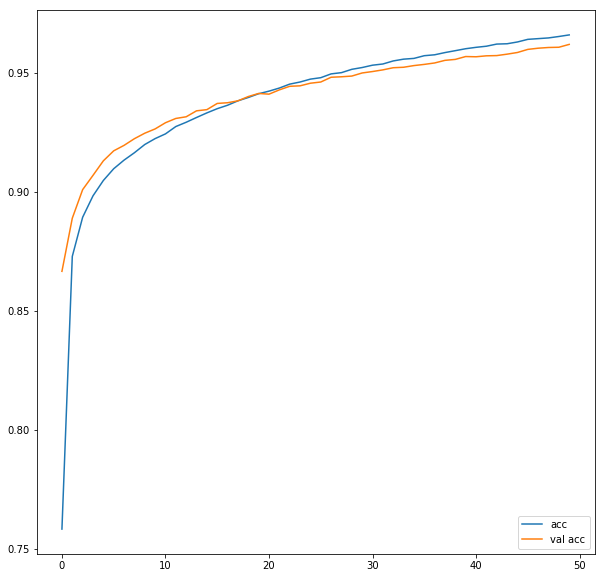

In [14]:
plt.plot(history_nn.history['acc'], label='acc')
plt.plot(history_nn.history['val_acc'], label='val acc')
plt.legend(loc='lower right')
plt.show()

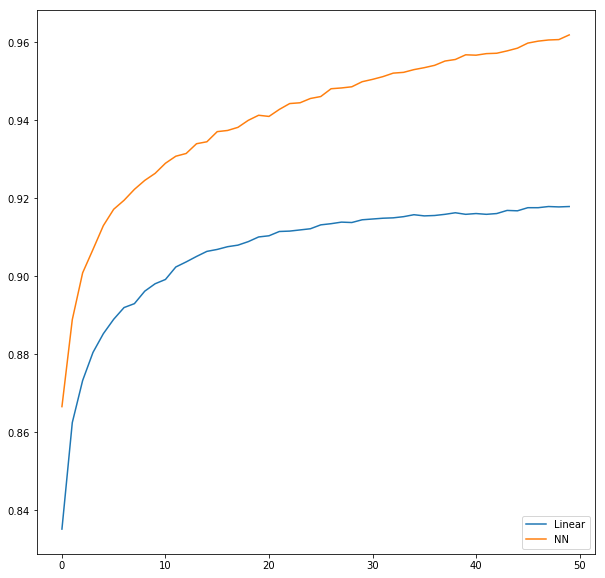

In [15]:
# Compare the two models
plt.plot(history_linear.history['val_acc'], label='Linear')
plt.plot(history_nn.history['val_acc'], label='NN')
plt.legend(loc='lower right')
plt.show()

## Convolutional model

In [16]:
#Define the model
print('Convolutional model...')
print('LeNet architecture.')

#Inputs
images = layers.Input(batch_shape=(None, 28, 28, 1), dtype='float32', name='Images')

#First convolutional layer
conv1 = layers.Conv2D(20, (5,5))(images)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

#Second convolutional layer
conv2 = layers.Conv2D(20, (5,5))(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

#Flatten convolution output
flat = layers.Flatten(name='Flat_image')(pool2)

# First dense layer
dense1 = layers.Dense(500, activation='relu', name='Dense_1')(flat)

# Second dense layer
output = layers.Dense(10, activation='softmax', name='Dense_output')(dense1)

# Model Architecture defined
model_conv = models.Model(inputs=images, outputs=output)
model_conv.summary()


Convolutional model...
LeNet architecture.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Images (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 20)          10020     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 20)          0         
_________________________________________________________________
Flat_image (Flatten)         (None, 320)               0         
_________________________________________________________________
Dense_1 (Dense)              (Non

In [17]:
# Compile model and select optimizer
sgd_optimizer = optimizers.SGD(lr=0.01)
model_conv.compile(loss='sparse_categorical_crossentropy', optimizer=sgd_optimizer, metrics=['accuracy'])


In [18]:
# Train the model
X_train_img = X_train.reshape(X_train.shape[0], 28, 28, 1) 
X_test_img = X_test.reshape(X_test.shape[0], 28, 28, 1)

start = time.time()

tb_callback_cnn = callbacks.TensorBoard(log_dir='/tmp/tensorboard/keras/CNN/')

history = model_conv.fit(X_train_img, y_train, batch_size=128, epochs=10,
                    verbose=1, validation_data=(X_test_img, y_test), callbacks=[tb_callback_cnn])

print('Seconds to train: ', time.time() - start)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s - loss: 0.9258 - acc: 0.7518 - val_loss: 0.3065 - val_acc: 0.9060
Epoch 2/10
60000/60000 [==============================] - 2s - loss: 0.2658 - acc: 0.9205 - val_loss: 0.2017 - val_acc: 0.9390
Epoch 3/10
60000/60000 [==============================] - 2s - loss: 0.1919 - acc: 0.9430 - val_loss: 0.1535 - val_acc: 0.9546
Epoch 4/10
60000/60000 [==============================] - 2s - loss: 0.1532 - acc: 0.9547 - val_loss: 0.1221 - val_acc: 0.9634
Epoch 5/10
60000/60000 [==============================] - 2s - loss: 0.1275 - acc: 0.9621 - val_loss: 0.1121 - val_acc: 0.9670
Epoch 6/10
60000/60000 [==============================] - 2s - loss: 0.1108 - acc: 0.9665 - val_loss: 0.0945 - val_acc: 0.9726
Epoch 7/10
60000/60000 [==============================] - 2s - loss: 0.0987 - acc: 0.9710 - val_loss: 0.0915 - val_acc: 0.9724
Epoch 8/10
60000/60000 [==============================] - 2s 

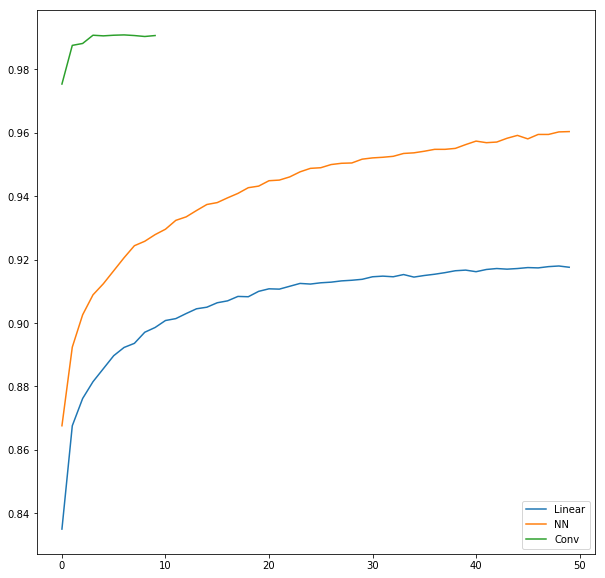

In [18]:
#Compare with previous
# Compare the two models
plt.plot(history_linear.history['val_acc'], label='Linear')
plt.plot(history_nn.history['val_acc'], label='NN')
plt.plot(history.history['val_acc'], label='Conv')
plt.legend(loc='lower right')
plt.show()


In [19]:
# Score and select prediction with max prob
import numpy as np
p_test = model_conv.predict(X_test_img)
pred_test = np.argmax(p_test, axis=1)

#Evaluate the confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, pred_test))

[[ 972    0    0    0    0    1    3    1    2    1]
 [   0 1128    2    0    0    0    1    2    2    0]
 [   0    0 1021    1    1    0    0    3    6    0]
 [   0    0    0 1002    0    4    0    1    3    0]
 [   0    0    1    0  974    0    2    0    0    5]
 [   2    0    0    4    0  882    1    1    2    0]
 [   3    2    0    0    1    3  948    0    1    0]
 [   0    3    4    0    0    0    0 1017    1    3]
 [   1    0    1    1    0    0    0    1  968    2]
 [   1    0    1    1    8    0    1    1    1  995]]


n:  1 - Pred 1: 9(0.715) - Pred 2: 4(0.285)
n:  2 - Pred 1: 2(0.957) - Pred 2: 4(0.041)
n:  3 - Pred 1: 5(1.000) - Pred 2: 3(0.000)
n:  4 - Pred 1: 2(0.942) - Pred 2: 8(0.054)
n:  5 - Pred 1: 8(0.586) - Pred 2: 1(0.408)
n:  6 - Pred 1: 4(0.791) - Pred 2: 2(0.123)
n:  7 - Pred 1: 7(0.684) - Pred 2: 1(0.269)
n:  8 - Pred 1: 8(0.972) - Pred 2: 5(0.028)
n:  9 - Pred 1: 8(0.813) - Pred 2: 9(0.187)
n: 10 - Pred 1: 9(0.896) - Pred 2: 8(0.103)
n: 11 - Pred 1: 5(0.990) - Pred 2: 8(0.008)
n: 12 - Pred 1: 1(0.589) - Pred 2: 4(0.265)
n: 13 - Pred 1: 6(0.948) - Pred 2: 4(0.052)
n: 14 - Pred 1: 5(0.851) - Pred 2: 8(0.131)
n: 15 - Pred 1: 2(0.987) - Pred 2: 7(0.012)
n: 16 - Pred 1: 4(0.737) - Pred 2: 9(0.204)
n: 17 - Pred 1: 9(0.657) - Pred 2: 4(0.340)
n: 18 - Pred 1: 7(0.917) - Pred 2: 5(0.081)
n: 19 - Pred 1: 3(0.913) - Pred 2: 8(0.070)
n: 20 - Pred 1: 3(0.868) - Pred 2: 5(0.132)
n: 21 - Pred 1: 4(0.287) - Pred 2: 0(0.256)
n: 22 - Pred 1: 6(0.560) - Pred 2: 4(0.439)
n: 23 - Pred 1: 3(0.671) - Pred 

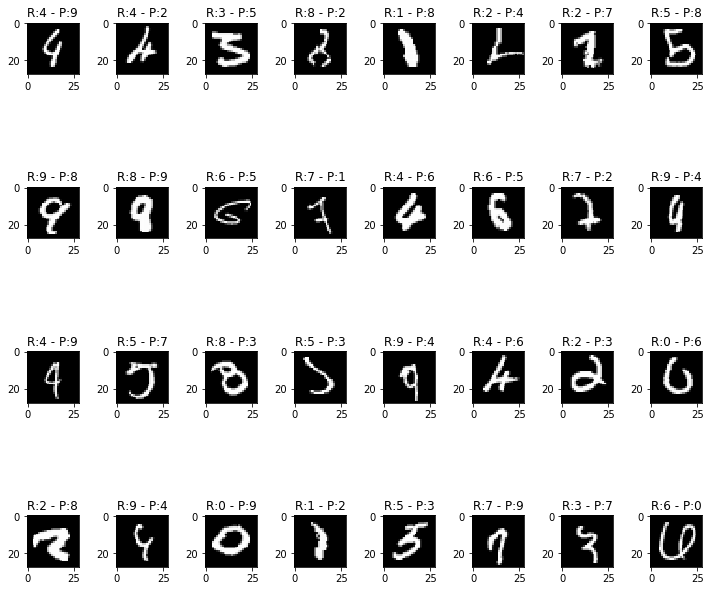

In [20]:

#Print probabilities to the first erros
test_errors=[]
test_errors_real=[]
test_errors_predict=[]
num_errors = 32
n = 0
for i in range(len(pred_test)):
    if pred_test[i] != y_test[i] and n < num_errors: #Error!
        n += 1
        test_errors += [X_test_img[i,:,:,0]]
        test_errors_real += [y_test[i]]
        test_errors_predict += [pred_test[i]]
        
        #Print first propabilities
        index = p_test[i].argsort()[::-1]
        print('n: %2i - Pred 1: %1i(%0.3f) - Pred 2: %1i(%0.3f)' % (n,
              index[0], p_test[i][index[0]], index[1], p_test[i][index[1]]))
        
print("Num errors: ", len(test_errors))


#Plot 32 images wrong classified.
fig = plt.figure()
for n, i in enumerate(range(32)): 
    a = fig.add_subplot(4,8,n+1)
    a.set_title('R:'+str(test_errors_real[i])+' - P:'+str(test_errors_predict[i]))
    fig.tight_layout()
    plt.imshow(test_errors[i])
    

# Input batch example
    - Define a batch generator
    - Use it in the train process

In [21]:
# New model. Equal to the last.
model_conv2 = models.Model(inputs=images, outputs=output)

sgd_optimizer = optimizers.SGD(lr=0.01, momentum=0.99, decay=0.005, nesterov=True)
model_conv2.compile(loss='sparse_categorical_crossentropy', optimizer=sgd_optimizer, metrics=['accuracy'])


In [22]:
# Define a generator to X_train. Same code to an HDF5 source
def batch_generator(X, y, batch_size=64):
    data_size = X.shape[0]
    while 1:
        # Randomize batches in each epoch
        batch_randomized = np.random.permutation(range(0, data_size-batch_size, batch_size))
        # Iterate over each batch
        for batch in batch_randomized:
            x_batch = X[batch : batch+batch_size]
            y_batch = y[batch : batch+batch_size]
            yield x_batch, y_batch

In [23]:
#Test the generator
seq = batch_generator(X_train_img, y_train)    
next_seq = next(seq)
print(next_seq[0][0].shape)
print(next_seq[1])


(28, 28, 1)
[5 8 3 2 5 0 8 0 4 1 6 7 8 6 4 3 3 2 3 1 6 7 5 3 9 1 1 3 4 9 5 1 7 7 4 6 1
 8 6 4 2 3 1 1 7 4 7 0 9 5 4 3 5 6 4 9 7 6 5 1 2 7 3 4]


In [24]:
# Train using the fit_generator function

# Number of steps to use all the train data in a epoch.
steps = X_train.shape[0]//64

history = model_conv2.fit_generator(batch_generator(X_train_img, y_train, batch_size=64),
                                    steps_per_epoch=steps, epochs=10,
                                    verbose=1, validation_data=(X_test_img, y_test))


Epoch 1/10
937/937 [==============================] - 5s - loss: 0.0966 - acc: 0.9750 - val_loss: 0.0560 - val_acc: 0.9845
Epoch 2/10
937/937 [==============================] - 5s - loss: 0.0313 - acc: 0.9910 - val_loss: 0.0383 - val_acc: 0.9890
Epoch 3/10
937/937 [==============================] - 5s - loss: 0.0148 - acc: 0.9956 - val_loss: 0.0364 - val_acc: 0.9904
Epoch 4/10
937/937 [==============================] - 5s - loss: 0.0086 - acc: 0.9977 - val_loss: 0.0358 - val_acc: 0.9910
Epoch 5/10
937/937 [==============================] - 5s - loss: 0.0060 - acc: 0.9987 - val_loss: 0.0366 - val_acc: 0.9909
Epoch 6/10
937/937 [==============================] - 5s - loss: 0.0048 - acc: 0.9990 - val_loss: 0.0378 - val_acc: 0.9908
Epoch 7/10
937/937 [==============================] - 5s - loss: 0.0039 - acc: 0.9994 - val_loss: 0.0386 - val_acc: 0.9910
Epoch 8/10
937/937 [==============================] - 5s - loss: 0.0034 - acc: 0.9995 - val_loss: 0.0385 - val_acc: 0.9908
Epoch 9/10
937/9